In [1]:
import os
import urllib.request
import tarfile
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import matplotlib.image as mpimg
from PIL import Image
from skimage.metrics import structural_similarity as ssim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
url = "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
file_name = "images.tar.gz"

urllib.request.urlretrieve(url, file_name)

with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall()

os.remove(file_name)

In [3]:
folder_path = 'images/'
image_size = 224
batch_size = 16

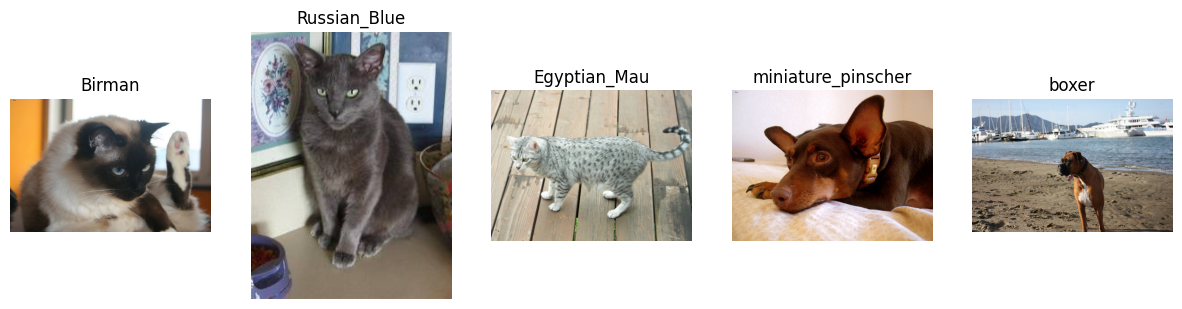

In [15]:
def visualize_pet_images(folder_path, num_images=5):
    plt.figure(figsize=(15, 8))

    pet_images = [file for file in os.listdir(folder_path) if file.endswith('.jpg')]

    selected_images = random.sample(pet_images, num_images)

    for i, image in enumerate(selected_images, start=1):
        image_path = os.path.join(folder_path, image)
        breed = '_'.join(image.split('_')[:-1])

        img = mpimg.imread(image_path)
        plt.subplot(1, num_images, i)
        plt.imshow(img)
        plt.title(breed)
        plt.axis('off')

    plt.show()

visualize_pet_images(folder_path, num_images=5)

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Изменение размера изображения
    transforms.ToTensor(),  # Преобразование изображения в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация данных
])

test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Изменение размера изображения
    transforms.ToTensor(),  # Преобразование изображения в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация данных
])

train_data = datasets.ImageFolder(root="images_split/train", transform=train_transforms)
test_data = datasets.ImageFolder(root="images_split/test", transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

len(train_loader), len(test_loader)


(370, 93)

In [ ]:
X_batch, y_batch = next(iter(train_loader))
X_batch.shape, y_batch.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512*14*14, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 512*14*14)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 512, 14, 14)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = torch.sigmoid(self.deconv4(x))
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

In [ ]:
latent_dim = 500
epochs = 25
lr = 3e-4

In [ ]:
autoencoder_model = Autoencoder(latent_dim).to(device)
optimizer = torch.optim.Adam(autoencoder_model.parameters(), lr=lr)
criterion = nn.MSELoss()

train_loss_history = []
test_loss_history = []

In [ ]:
for epoch in range(epochs):
    autoencoder_model.train()  # Установка модели в режим обучения

    total_train_loss = 0.0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
        data = data.to(device)

        optimizer.zero_grad()

        # Прямой проход
        outputs = autoencoder_model(data)

        # Вычисление потерь
        train_loss =criterion(outputs, data)
        total_train_loss += train_loss.item()

        # Обратный проход
        train_loss.backward()
        optimizer.step()

    # Вычисляем потери и точность на тестовом наборе данных
    autoencoder_model.eval()  # Установка модели в режим оценки (не обучения)
    total_test_loss = 0.0
    with torch.no_grad():
        for data, _ in tqdm(test_loader, desc=f'Testing Epoch {epoch+1}/{epochs}'):
            data = data.to(device)
            outputs = autoencoder_model(data)
            test_loss = criterion(outputs, data)
            total_test_loss += test_loss.item()

    # Сохраняем потери для train и test
    train_loss_history.append(total_train_loss / len(train_loader.dataset))
    test_loss_history.append(total_test_loss / len(test_loader.dataset))

    # Выводим потери на этапе обучения и теста
    print('Epoch {}, Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, train_loss_history[-1], test_loss_history[-1]))


Testing Epoch 1/25: 100%|██████████| 93/93 [00:18<00:00,  5.14it/s]


Epoch 1, Train Loss: 0.0778, Test Loss: 0.0649


Testing Epoch 2/25: 100%|██████████| 93/93 [00:16<00:00,  5.53it/s]


Epoch 2, Train Loss: 0.0612, Test Loss: 0.0612


Testing Epoch 3/25: 100%|██████████| 93/93 [00:17<00:00,  5.35it/s]


Epoch 3, Train Loss: 0.0589, Test Loss: 0.0597


Testing Epoch 4/25: 100%|██████████| 93/93 [00:16<00:00,  5.70it/s]


Epoch 4, Train Loss: 0.0573, Test Loss: 0.0582


Testing Epoch 5/25: 100%|██████████| 93/93 [00:15<00:00,  5.83it/s]


Epoch 5, Train Loss: 0.0561, Test Loss: 0.0573


Testing Epoch 6/25: 100%|██████████| 93/93 [00:15<00:00,  5.87it/s]


Epoch 6, Train Loss: 0.0553, Test Loss: 0.0568


Testing Epoch 7/25: 100%|██████████| 93/93 [00:17<00:00,  5.37it/s]


Epoch 7, Train Loss: 0.0547, Test Loss: 0.0563


Testing Epoch 8/25: 100%|██████████| 93/93 [00:19<00:00,  4.82it/s]


Epoch 8, Train Loss: 0.0542, Test Loss: 0.0559


Testing Epoch 9/25: 100%|██████████| 93/93 [00:18<00:00,  4.96it/s]


Epoch 9, Train Loss: 0.0538, Test Loss: 0.0557


Testing Epoch 10/25: 100%|██████████| 93/93 [00:15<00:00,  5.91it/s]


Epoch 10, Train Loss: 0.0535, Test Loss: 0.0557


Testing Epoch 11/25: 100%|██████████| 93/93 [00:16<00:00,  5.80it/s]


Epoch 11, Train Loss: 0.0532, Test Loss: 0.0555


Testing Epoch 12/25: 100%|██████████| 93/93 [00:16<00:00,  5.73it/s]


Epoch 12, Train Loss: 0.0529, Test Loss: 0.0555


Testing Epoch 13/25: 100%|██████████| 93/93 [00:16<00:00,  5.71it/s]


Epoch 13, Train Loss: 0.0526, Test Loss: 0.0554


Testing Epoch 14/25: 100%|██████████| 93/93 [00:15<00:00,  5.92it/s]


Epoch 14, Train Loss: 0.0524, Test Loss: 0.0555


Testing Epoch 15/25: 100%|██████████| 93/93 [00:16<00:00,  5.62it/s]


Epoch 15, Train Loss: 0.0522, Test Loss: 0.0554


Testing Epoch 16/25: 100%|██████████| 93/93 [00:16<00:00,  5.80it/s]


Epoch 16, Train Loss: 0.0521, Test Loss: 0.0554


Testing Epoch 17/25: 100%|██████████| 93/93 [00:17<00:00,  5.28it/s]


Epoch 17, Train Loss: 0.0519, Test Loss: 0.0554


Testing Epoch 18/25: 100%|██████████| 93/93 [00:15<00:00,  5.87it/s]


Epoch 18, Train Loss: 0.0518, Test Loss: 0.0553


Testing Epoch 19/25: 100%|██████████| 93/93 [00:16<00:00,  5.48it/s]


Epoch 19, Train Loss: 0.0517, Test Loss: 0.0553


Testing Epoch 20/25: 100%|██████████| 93/93 [00:16<00:00,  5.65it/s]


Epoch 20, Train Loss: 0.0515, Test Loss: 0.0555


Testing Epoch 21/25: 100%|██████████| 93/93 [00:16<00:00,  5.50it/s]


Epoch 21, Train Loss: 0.0515, Test Loss: 0.0554


Testing Epoch 22/25: 100%|██████████| 93/93 [00:17<00:00,  5.19it/s]


Epoch 22, Train Loss: 0.0514, Test Loss: 0.0553


Testing Epoch 23/25: 100%|██████████| 93/93 [00:16<00:00,  5.68it/s]


Epoch 23, Train Loss: 0.0514, Test Loss: 0.0553


Testing Epoch 24/25: 100%|██████████| 93/93 [00:15<00:00,  5.91it/s]


Epoch 24, Train Loss: 0.0512, Test Loss: 0.0553


Testing Epoch 25/25: 100%|██████████| 93/93 [00:14<00:00,  6.43it/s]

Epoch 25, Train Loss: 0.0512, Test Loss: 0.0553


In [ ]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data, _ in tqdm(test_loader, desc='Testing'):
            data = data.to(device)
            outputs = model(data)
            loss = criterion(outputs, data)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader.dataset)
    print('Average Test Loss: {:.4f}'.format(avg_loss))
    return avg_loss

test_avg_loss = test_model(autoencoder_model, test_loader, criterion, device)

Testing: 100%|██████████| 93/93 [00:15<00:00,  6.18it/s]

Average Test Loss: 0.0553


In [ ]:
def visualize_images(model, test_loader, num_images=5, device='cuda'):
    model.eval()
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            if i >= num_images:
                break
            data = data.to(device)
            outputs = model(data)

            original_img = data.cpu().numpy().transpose(0, 2, 3, 1)
            reconstructed_img = outputs.cpu().numpy().transpose(0, 2, 3, 1)

            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(original_img[0])
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            axes[1].imshow(reconstructed_img[0])
            axes[1].set_title('Reconstructed Image')
            axes[1].axis('off')
            plt.show()

visualize_images(autoencoder_model, test_loader)

NameError: name 'autoencoder_model' is not defined